In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torchvision import transforms

In [ ]:
def preprocess_text(text):
        stop_words = set(stopwords.words('english'))
        ps = PorterStemmer()
        
        text = re.sub(r'[,.!?{}%\[\]#()]', '', text)
        text = re.sub(r'\n+', ' ', text)

        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        
        tokens = word_tokenize(text)  # Tokenization
        tokens = [token for token in tokens if
                  token.isalpha() and token not in stop_words and len(token) > 1]  # Remove non-alphanumeric and stop words
    
        stemmed_tokens = [ps.stem(token) for token in tokens]
        
        return stemmed_tokens

def get_tokenized_text(training_column)
    import re
    
    from gensim import corpora, models
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer
    from gensim.models import Phrases
    from gensim.models.phrases import Phraser
    all_texts = training_column.apply(TopicAnalysis.preprocess_text)
    dictionary = corpora.Dictionary(all_texts)
    corpus = [self.dictionary.doc2bow(text) for text in all_texts_phrases]

I did some tests with natural language processing, and I left some of the code for that above to demonstrate. My original approach was to convert the tweets into bag of words format and run those through a neural network to train. While doing reading on that, I discovered that pre-trained NLP networks exists and can be converted to our purpose. This seemed like the correct approach to the problem in the real world.

In [3]:
data = pd.read_csv('data/DisasterTweets/train.csv')

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Printed out some sample rows to get an idea of what exactly is contained in the data set. Pretty straightforward, tweet text and target are what I'm most interested in.

In [5]:
from sklearn.model_selection import train_test_split
X = data['text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
print(len(X_train))

6471


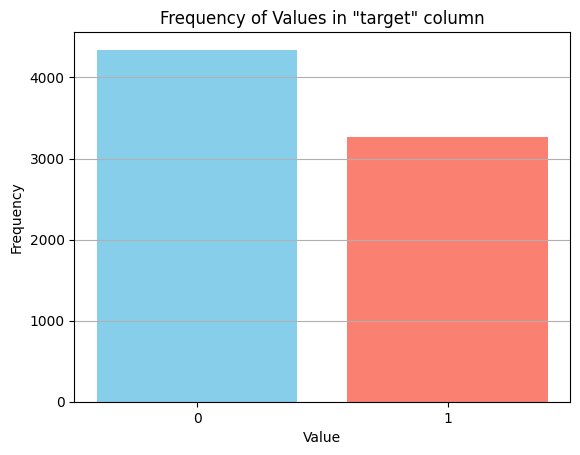

In [7]:
value_counts = data['target'].value_counts()
plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'salmon'])
plt.title('Frequency of Values in "target" column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(value_counts.index)  # Setting x-axis ticks to the unique values in 'target'
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()

I'm not sure how close to 50/50 the data needs to be, but this seemed close enough to not need balancing to me, which is convenient.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [9]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels=None):
        self.tweets = tweets.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        if self.labels is not None:
            label = self.labels[idx]
        else:
            label = None
        return tweet, label

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(bert_model.config.hidden_size, 48)
        self.fc2 = nn.Linear(48, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc(x)
        logits = self.fc2(x)
        return logits

In [11]:
num_classes = 2
learning_rate = 2e-5
batch_size = 16
num_epochs = 15

In [12]:
train_dataset = TweetDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TweetDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
model = BERTClassifier(bert_model, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [14]:
import torch.nn.functional as F

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for i, (texts, labels) in enumerate(train_loader, 1):
        labels = labels.to(device)
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
        inputs = inputs.to(device)
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        
        # Print progress every 'print_freq' iterations
        print_freq = 120  # Change this value as needed
        if i % print_freq == 0:
            avg_loss = running_loss / print_freq
            print(f"Iteration [{i}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0  # Reset running loss

    model.eval()
    test_running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for texts, labels in test_loader:
            labels = labels.to(device)
            inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
            inputs = inputs.to(device)
            logits = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
            probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities using softmax
            loss = criterion(probabilities, labels)
            test_running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(probabilities, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    avg_test_loss = test_running_loss / len(test_loader)
    accuracy = total_correct / total_samples
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    torch.save(model.state_dict(), f'bert_classifier_epoch_{epoch+1}.pt')

Epoch 1/15
Iteration [120/405], Loss: 0.5324
Iteration [240/405], Loss: 0.4249
Iteration [360/405], Loss: 0.4058
Test Loss: 0.4938
Accuracy: 0.8363
Epoch 2/15
Iteration [120/405], Loss: 0.2879
Iteration [240/405], Loss: 0.3315
Iteration [360/405], Loss: 0.3168
Test Loss: 0.5149
Accuracy: 0.8030
Epoch 3/15
Iteration [120/405], Loss: 0.1908
Iteration [240/405], Loss: 0.2221
Iteration [360/405], Loss: 0.2234
Test Loss: 0.4992
Accuracy: 0.8117
Epoch 4/15
Iteration [120/405], Loss: 0.1396
Iteration [240/405], Loss: 0.1248
Iteration [360/405], Loss: 0.1645
Test Loss: 0.4836
Accuracy: 0.8222
Epoch 5/15
Iteration [120/405], Loss: 0.0870
Iteration [240/405], Loss: 0.1300
Iteration [360/405], Loss: 0.0939
Test Loss: 0.4843
Accuracy: 0.8231
Epoch 6/15
Iteration [120/405], Loss: 0.0682
Iteration [240/405], Loss: 0.0924
Iteration [360/405], Loss: 0.0792
Test Loss: 0.4808
Accuracy: 0.8222
Epoch 7/15
Iteration [120/405], Loss: 0.0411
Iteration [240/405], Loss: 0.0809
Iteration [360/405], Loss: 0.0529

I saved the model every epoch, set the code to run, and walked away instead of monitoring for early stopping. Looks like there's a break in how fast the loss decreases after epoch 4, so decided to use the model produced at that point. 80% accuracy on the test data seems good.

In [18]:
test_df = pd.read_csv('data/DisasterTweets/test.csv')
test_df['label'] = 0
dataset = TweetDataset(test_df['text'], test_df['label'])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = BERTClassifier(bert_model, num_classes)
model.load_state_dict(torch.load('bert_classifier_epoch_4.pt'))
model.to(device)
model.eval()

predictions = []
with torch.no_grad():
    for texts, _ in dataloader:
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())

test_df['target'] = predictions

test_df[['id', 'target']].to_csv('data/DisasterTweets/predictions.csv', index=False)